# **ML-Based Curvature Estimation Within a VOF Framework - Binary Classification**



In [1]:
# Import All Needed Libraries
import numpy as np
import pandas as pd

import math

import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as init

from torch.utils.data import TensorDataset, DataLoader

# Generate Grid

2D Grid Generation Function that generates a simple 2D orthogonal grid.


In [3]:
def genGrid2D(nx, ny, xsize, ysize, plotNow=True):

    dx = xsize / nx
    dy = ysize / ny

    # Generate grid points
    x = np.linspace(0, xsize, nx+1)
    y = np.linspace(0, ysize, ny+1)

    # Create 2D grid
    X, Y = np.meshgrid(x, y, indexing='xy')

    # Flatten the grid points
    gridPts = np.column_stack((X.ravel(order='C'), Y.ravel(order='C')))

    # Locate centroids
    Centroids = []
    for i in range(ny):
        for j in range(nx):
            centroid_x = (X[i, j] + X[i+1, j] + X[i, j+1] + X[i+1, j+1]) / 4
            centroid_y = (Y[i, j] + Y[i+1, j] + Y[i, j+1] + Y[i+1, j+1]) / 4
            Centroids.append([centroid_x, centroid_y])

    Centroids = np.array(Centroids)
    numElems = len(Centroids)

    # Plot Grid
    if plotNow == True:
      plotGridAndCentroids(gridPts, Centroids, nx, ny, plotNow=True)

    return dx, dy, gridPts, Centroids, numElems

Plotting Function to visualize generated grid, shows grid points and centroids.

In [4]:
def plotGridAndCentroids(gridPts, Centroids, nx, ny, plotNow=True):
      if plotNow == True:
        # Initialize the plot
        fig, ax = plt.subplots()

        # Plot horizontal lines
        for j in range(nx + 1):
            ax.plot(gridPts[j::nx+1, 0], gridPts[j::nx+1, 1], 'b--', linewidth=1)
        # Plot vertical lines
        for i in range(ny + 1):
            ax.plot(gridPts[i*(nx+1):(i+1)*(nx+1), 0], gridPts[i*(nx+1):(i+1)*(nx+1), 1], 'b--', linewidth=1)

        # Scatter the centroids and gridpts
        ax.scatter(gridPts[:,0], gridPts[:,1], s=10, color='black', label='Grid Points')
        ax.scatter(Centroids[:,0], Centroids[:,1], s=10, color='red', label='Centroids')
        ax.set_xlim(0, max(gridPts[:,0]))
        ax.set_ylim(0, max(gridPts[:,1]))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title('2D Grid')
        ax.legend()
        ax.grid(True)
        plt.show()


# Generate VOF Field

In [5]:
def genVOFCircularField(dx, dy, nx, ny, numElems, gridPts, Centroids, circleCenter, R, plotNow=True):
    # Initialize volume fraction array
    volFracField = np.zeros((numElems,1))

    # Compute volume fraction
    for i in range(ny):
        for j in range(nx):
            index = i * nx + j

            # Step 1 : Calcualte Distances from Corners to Center
            # Indicies
            bottomLeftIdx = i * (nx + 1) + j                 # P1
            bottomRightIdx = i * (nx + 1) + (j + 1)          # P2
            topLeftIdx = (i + 1) * (nx + 1) + j              # P3
            topRightIdx = (i + 1) * (nx + 1) + (j + 1)       # P4
            # Distancies
            OP1 = math.sqrt((gridPts[topLeftIdx][0]-circleCenter[0])**2 + (gridPts[topLeftIdx][1]-circleCenter[1])**2)
            OP2 = math.sqrt((gridPts[topRightIdx][0]-circleCenter[0])**2 + (gridPts[topRightIdx][1]-circleCenter[1])**2)
            OP3 = math.sqrt((gridPts[bottomLeftIdx][0]-circleCenter[0])**2 + (gridPts[bottomLeftIdx][1]-circleCenter[1])**2)
            OP4 = math.sqrt((gridPts[bottomRightIdx][0]-circleCenter[0])**2 + (gridPts[bottomRightIdx][1]-circleCenter[1])**2)

            # Step 2: Find max
            maxOP = max(OP1,OP2,OP3,OP4)

            # Step 3: Find min
            minOP = min(OP1,OP2,OP3,OP4)

            # Step 4: Estimate Volume Fraction
            if maxOP <= R:
              volFracField[index] = 1
            elif minOP >= R:
              volFracField[index] = 0
            else : # min<R && max>R ==> Interfacial Element
              volFracField[index] = (R-minOP) / (maxOP-minOP)

    # Processing VolField before saving
    volFracField = np.round(volFracField, decimals=6)

    # Plot the contour of volume fraction
    if plotNow ==True:
      plotVOFField(Centroids, gridPts, nx,ny, volFracField, plotNow=True)

    return volFracField

In [6]:
def plotVOFField(Centroids, gridPts, nx,ny, volFracField, plotNow=True):
      if plotNow ==True:
        # Initialize the plot
        fig, ax = plt.subplots()

        contour = ax.contourf(Centroids[:,0].reshape((ny, nx)), Centroids[:,1].reshape((ny, nx)), volFracField.reshape((ny, nx)), levels=[0,0.1,0.2 ,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], cmap='coolwarm')
        ax.set_xlim(min(gridPts[:,0]),max(gridPts[:,0]))
        ax.set_ylim(min(gridPts[:,1]),max(gridPts[:,1]))
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        cbar = plt.colorbar(contour, ax=ax)
        ax.set_title('Contours of Volume Fraction')
        ax.set_aspect('equal', adjustable='box')
        plt.show()

# Generate Volume Fraction Field and prepare data for NN

Test Run on a sample Circular Interface

In [13]:
nx = 500
ny = 500
xsize = 10
ysize = 10

dx, dy, gridPts, Centroids, numElems = genGrid2D(nx, ny, xsize, ysize, plotNow=False)

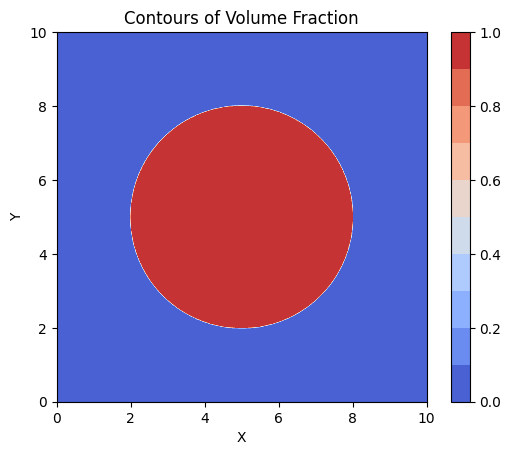

In [14]:
# Define ellipse center
circleCenter = [5, 5]

# Given parameters
R = 3

# Generate Volume Fraction Fields
volFracField = genVOFCircularField(dx, dy, nx, ny, numElems, gridPts, Centroids, circleCenter, R, plotNow=True)
# Note:
#   plotNow can be set to False if user would not like to visualize VOF contour
#   VOF is calcualted for all elements within domain, even boundary elems, however, sometimes boundnary elements are not shown in contour. This is a visual representation bug only.

Data Preproccessing

In [16]:
# INPUT : CENTROIDS X Y
# Apply threshold rounding
volFracField[volFracField < 0.2] = 0
volFracField[volFracField > 0.8] = 1

# OUTPUT VOF EITHER ZERO OR 1
# Create a boolean array where only the conditions 0 or 1 are True
valid_indices = (volFracField == 0) | (volFracField == 1)
valid_indices = valid_indices.flatten()  # Flatten to make it a 1D array

# Filter the volFracField and Centroids using the 1D boolean array
filtered_volFracField = volFracField[valid_indices]
filtered_Centroids = Centroids[valid_indices]


**NOTE: DO NOT RUN FOR LARGE GRIDS. HAS A HIGH EXECUTION TIME**

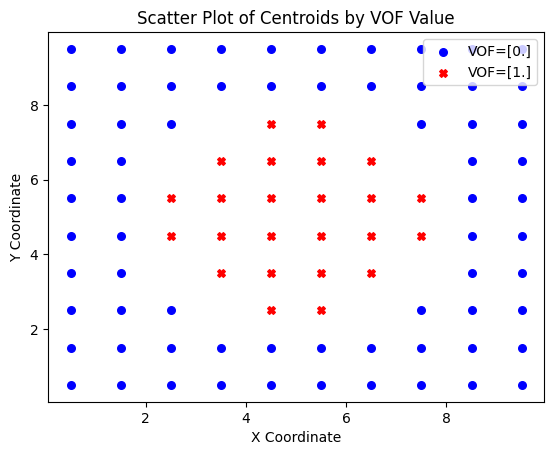

In [12]:
# Create the plot
fig, ax = plt.subplots()

# Scatter plot with conditions
for vof, centroid in zip(filtered_volFracField, filtered_Centroids):
    if vof == 1:
        marker = 'X'
        color = 'red'
    else:
        marker = 'o'
        color = 'blue'
    ax.scatter(centroid[0], centroid[1], marker=marker, color=color, label=f'VOF={vof}', s=30)

# Improve the legend
handles, labels = ax.get_legend_handles_labels()
unique_labels = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
ax.legend(*zip(*unique_labels))

# Label axes
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Scatter Plot of Centroids by VOF Value')

# Show plot
plt.show()

In [17]:
x_tensor = torch.tensor(filtered_Centroids, dtype=torch.float32)
y_tensor = torch.tensor(filtered_volFracField, dtype=torch.float32)

## STACK VECTORS ALL THE WAY TO QUADRATIC
X = x_tensor[:, 0]  # All rows, first column
Y = x_tensor[:, 1]  # All rows, second column

# Calculate quadratic features
X2 = X ** 2
Y2 = Y ** 2
XY = X * Y
constant = torch.ones_like(X)  # Constant term, same shape as X

# Concatenate all features: original features, quadratic features, and constant
x_tensor = torch.stack([X, Y, X2, Y2, XY, constant], dim=1)

**NOTE: Choose one architecture from the ones below, either single or double hidden layer.**

ONE LAYER Binary Classification NN

In [18]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(6, 1)
        self.fc2 = nn.Linear(1, 1)

    def forward(self, x):
        # Use the sigmoid activation function between layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

net = Net()

TWO LAYER Binary Classification NN

In [ ]:
# Define the neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(6, 4)
        self.fc2 = nn.Linear(4, 1)
        self.fc3 = nn.Linear(1, 1)

    def forward(self, x):
        # Use the sigmoid activation function between layers
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

net = Net()

Definition of Loss and hyperparameters

In [ ]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)
##scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)

Epochs = 2000
batchSize = 128

trainSetSize = 0.7
valSetSize = 0.2
testSetSize = 1- trainSetSize - valSetSize

In [ ]:
# Split the data into training and test sets
train_size = int(trainSetSize * len(x_tensor))
validate_size = int(valSetSize * len(x_tensor))
test_size = len(x_tensor) - train_size - validate_size

x_train, x_validate, x_test = torch.split(x_tensor, [train_size, validate_size, test_size])
y_train, y_validate, y_test = torch.split(y_tensor, [train_size, validate_size, test_size])

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(dataset=train_dataset, batch_size=batchSize, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=batchSize, shuffle=False)


In [ ]:
# Train step function
def train_step(model, criterion, optimizer, x, y):
    model.train()
    optimizer.zero_grad()
    output = model(x)
    y = y.view(-1, 1)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item()


In [ ]:
# Validation step function
def validation_step(model, criterion, x, y):
    model.eval()
    with torch.no_grad():
        output = model(x)
        y = y.view(-1, 1)
        loss = criterion(output, y)
    return loss.item()


In [ ]:
# Training and evaluation loop with loss tracking
def train_and_evaluate(model, criterion, optimizer, train_loader, test_loader, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            train_loss += train_step(model, criterion, optimizer, x_batch, y_batch)
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        for x_batch, y_batch in test_loader:
            val_loss += validation_step(model, criterion, x_batch, y_batch)
        val_loss /= len(test_loader)
        val_losses.append(val_loss)

        # Update the learning rate
        ##scheduler.step()

        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{epochs}] Train Loss: {train_loss:.8f}, Validation Loss: {val_loss:.8f}')

    return train_losses, val_losses


In [ ]:
# Run the training and evaluation
train_losses, val_losses = train_and_evaluate(net, criterion, optimizer, train_loader, test_loader, epochs=Epochs)


Epoch [0/2000] Train Loss: 0.17063009, Validation Loss: 0.26288655
Epoch [100/2000] Train Loss: 0.00560569, Validation Loss: 0.00000000
Epoch [200/2000] Train Loss: 0.00368543, Validation Loss: 0.00000000
Epoch [300/2000] Train Loss: 0.00294521, Validation Loss: 0.00000000
Epoch [400/2000] Train Loss: 0.00253685, Validation Loss: 0.00000000
Epoch [500/2000] Train Loss: 0.00234155, Validation Loss: 0.00000000
Epoch [600/2000] Train Loss: 0.00214656, Validation Loss: 0.00000000
Epoch [700/2000] Train Loss: 0.00183905, Validation Loss: 0.00000000
Epoch [800/2000] Train Loss: 0.00171873, Validation Loss: 0.00000000
Epoch [900/2000] Train Loss: 0.00166226, Validation Loss: 0.00000000
Epoch [1000/2000] Train Loss: 0.00171649, Validation Loss: 0.00000000
Epoch [1100/2000] Train Loss: 0.00164305, Validation Loss: 0.00000000
Epoch [1200/2000] Train Loss: 0.00144346, Validation Loss: 0.00000000
Epoch [1300/2000] Train Loss: 0.00144849, Validation Loss: 0.00000000
Epoch [1400/2000] Train Loss: 0.

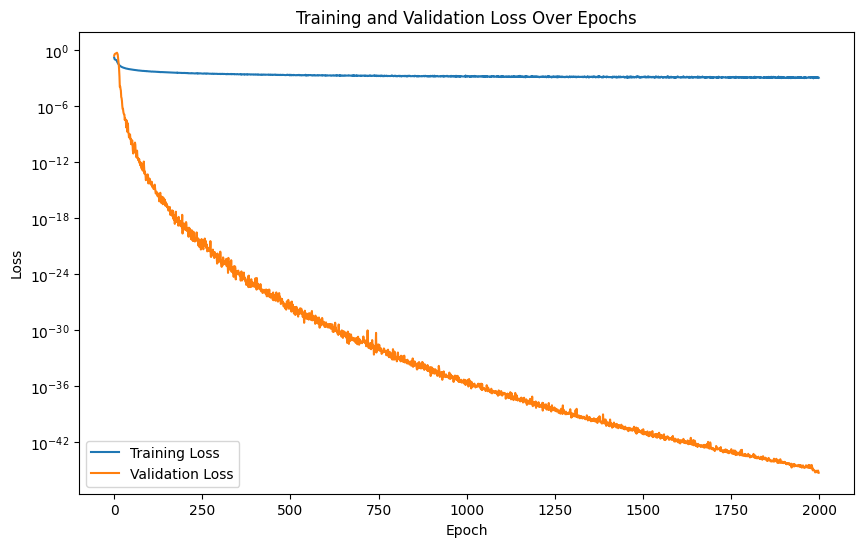

In [ ]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Analysis Single Hidden Layer

In [ ]:
# Extract the weights and biases from the first fully connected layer
fc1_weights = net.fc1.weight.data
fc1_biases = net.fc1.bias.data

# Assuming the input features are ordered as [X, Y, X**2, Y**2, XY, constant]
features = ['X', 'Y', 'X**2', 'Y**2', 'XY', 'constant']

# Print weights and biases for each feature
for i, feature in enumerate(features):
    print(f"Feature: {feature}")
    for neuron_idx, (weight, bias) in enumerate(zip(fc1_weights[:, i], fc1_biases)):
        print(f"  Neuron {neuron_idx}: Weight = {weight:.4f}, Bias = {bias:.4f}")


Feature: X
  Neuron 0: Weight = -5.6136, Bias = 11.3712
Feature: Y
  Neuron 0: Weight = -5.6122, Bias = 11.3712
Feature: X**2
  Neuron 0: Weight = 0.5636, Bias = 11.3712
Feature: Y**2
  Neuron 0: Weight = 0.5610, Bias = 11.3712
Feature: XY
  Neuron 0: Weight = 0.0011, Bias = 11.3712
Feature: constant
  Neuron 0: Weight = 11.2115, Bias = 11.3712


In [ ]:
    # Generate grid points
    x = np.linspace(0, xsize, nx+1)
    y = np.linspace(0, ysize, ny+1)

    # Create 2D grid
    X, Y = np.meshgrid(x, y, indexing='xy')

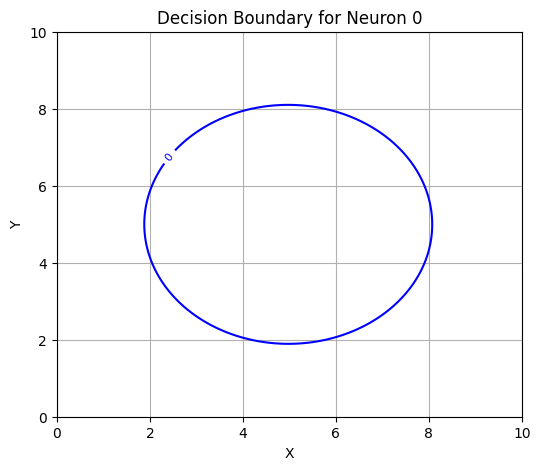

<ipython-input-21-a117dc9905b1>:40: UserWarning: The following kwargs were not used by contour: 'label'
  contour = plt.contour(X, Y, Z, levels=[0], label=f'Neuron {i}')


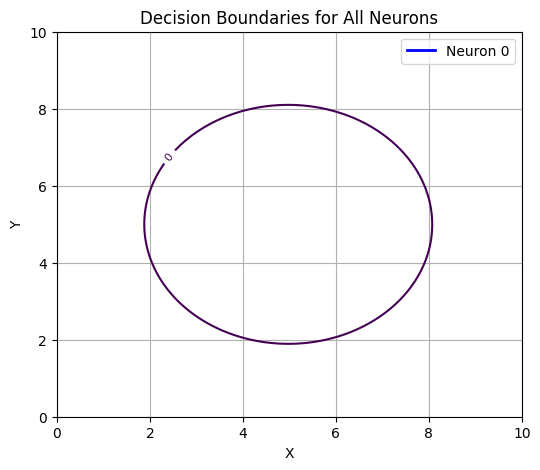

In [ ]:
# Number of neurons in the first layer
num_neurons = net.fc1.weight.shape[0]

# Plot each neuron's decision boundary on separate plots
for i in range(num_neurons):
    weights = net.fc1.weight.data[i]
    bias = net.fc1.bias.data[i]

    Z = (weights[0] * X +
         weights[1] * Y +
         weights[2] * X**2 +
         weights[3] * Y**2 +
         weights[4] * X * Y +
         weights[5] +  # Constant term
         bias)

    plt.figure(figsize=(6, 5))
    contour = plt.contour(X, Y, Z, levels=[0], colors='blue')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Decision Boundary for Neuron {i}')
    plt.clabel(contour, inline=True, fontsize=8)
    plt.grid(True)
    plt.show()

# Plot all neuron's decision boundaries together on the same plot
plt.figure(figsize=(6, 5))
for i in range(num_neurons):
    weights = net.fc1.weight.data[i]
    bias = net.fc1.bias.data[i]

    Z = (weights[0] * X +
         weights[1] * Y +
         weights[2] * X**2 +
         weights[3] * Y**2 +
         weights[4] * X * Y +
         weights[5] +  # Constant term
         bias)

    contour = plt.contour(X, Y, Z, levels=[0], label=f'Neuron {i}')
    plt.clabel(contour, inline=True, fontsize=8)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Decision Boundaries for All Neurons')
plt.grid(True)
plt.legend(handles=[plt.Line2D([0], [0], color='blue', lw=2, label=f'Neuron {i}') for i in range(num_neurons)])
plt.show()

# Analysis Two Hidden Layers

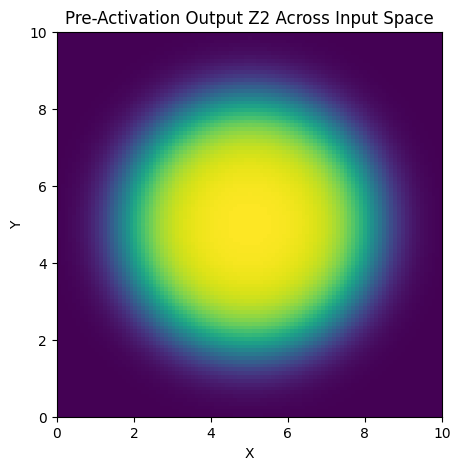

In [ ]:
# Create 2D grid
X, Y = np.meshgrid(x, y)

# Convert grid data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Calculate the output from the first layer
Z1 = torch.zeros(X.shape, dtype=torch.float32)

for i in range(net.fc1.weight.shape[0]):
    weights = net.fc1.weight[i]
    bias = net.fc1.bias[i]
    # Compute the sigmoid activation for each neuron in the first layer
    z = weights[0] * X_tensor + weights[1] * Y_tensor + weights[2] * X_tensor**2 + weights[3] * Y_tensor**2 + weights[4] * X_tensor * Y_tensor + weights[5] + bias
    Z1 += torch.sigmoid(z)

# Get the weights and bias for the second layer neuron
weights2 = net.fc2.weight[0]  # assuming there's only one output neuron in the second layer
bias2 = net.fc2.bias

# Calculate the pre-activation value for the second layer neuron
Z2 = weights2[0] * Z1 + bias2

# Convert Z2 to numpy for plotting
Z2_numpy = Z2.detach().numpy()

# Plot the entire range of Z2 values
plt.figure(figsize=(6, 5))
heatmap = plt.imshow(Z2_numpy, extent=(x.min(), x.max(), y.min(), y.max()), origin='lower', cmap='viridis')
#plt.colorbar(heatmap)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Pre-Activation Output Z2 Across Input Space')
plt.show()

In [ ]:
# Prepare to collect the equation parts
equation_parts = []

# Iterate through each neuron in the first layer
for i, (weights, bias) in enumerate(zip(net.fc1.weight, net.fc1.bias)):
    # Each neuron's equation from the first layer
    neuron_eq = f"sigmoid({weights[0]:.4f}*x1 + {weights[1]:.4f}*x2 + {weights[2]:.4f}*x1^2 + {weights[3]:.4f}*x2^2 + {weights[4]:.4f}*x1*x2 + {weights[5]:.4f} + {bias:.4f})"
    # Multiply by the corresponding weight from the second layer
    weighted_neuron_eq = f"({net.fc2.weight[0][i]:.4f} * {neuron_eq})"
    equation_parts.append(weighted_neuron_eq)

# Combine all parts of the equation and add the bias from the second layer
full_equation = " + ".join(equation_parts) + f" + {net.fc2.bias.item():.4f}"

print("Equation for Z2 (pre-activation) of the second layer neuron:")
print(full_equation)


Equation for Z2 (pre-activation) of the second layer neuron:
(-34.8679 * sigmoid(-3.2684*x1 + -3.2506*x2 + 0.3291*x1^2 + 0.3259*x2^2 + -0.0025*x1*x2 + 6.4672 + 6.4770)) + 13.8544
